In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

from utils import PointSampler, Normalize, pcshow

import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
SPHERE_PATH = "sphere.obj"

c:\BACKUP\Playdata\202105_lab\02.git\gan-exercise\sphereGAN\utils.py:91: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x, y, z, c=colors[i], marker="o", s=10)


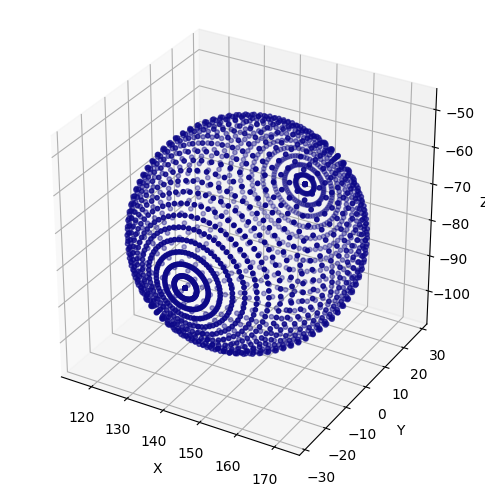

In [3]:
sphere_vertices = []
sphere_faces = []

with open(SPHERE_PATH, "r") as file:
    for line in file:
        if line.startswith("v "):
            parts = line.split()
            x, y, z = map(float, parts[1:4])
            sphere_vertices.append([x, y, z])
        elif line.startswith("f "):
            parts = line.split()
            face = [int(v.split("/")[0]) - 1 for v in parts[1:]]
            if len(face) == 3:
                sphere_faces.append(face)
            elif len(face) == 4:
                # Convert quads to triangles
                sphere_faces.append([face[0], face[1], face[2]])
                sphere_faces.append([face[0], face[2], face[3]])

sphere_vertices = np.array(sphere_vertices)
sphere_faces = np.array(sphere_faces)

pcshow(sphere_vertices, figsize=(6, 6))

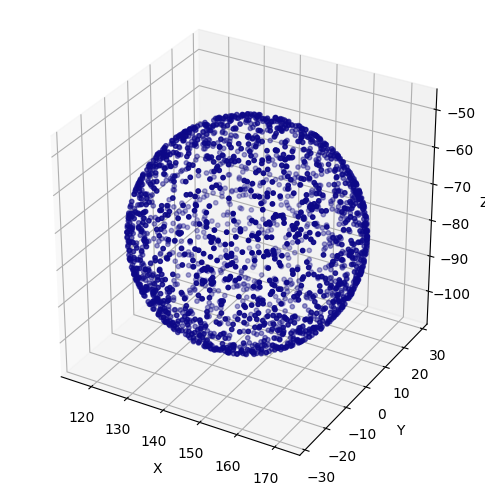

In [4]:
sampled_sphere = PointSampler(len(sphere_vertices))((sphere_vertices, sphere_faces))
pcshow(sampled_sphere, figsize=(6, 6))

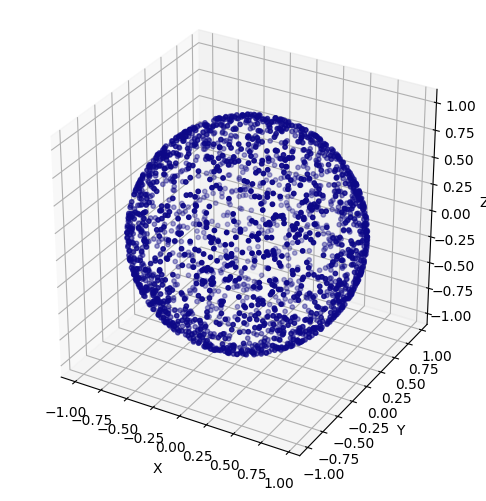

In [5]:
train_data = torch.FloatTensor(Normalize()(sampled_sphere))
pcshow(train_data)

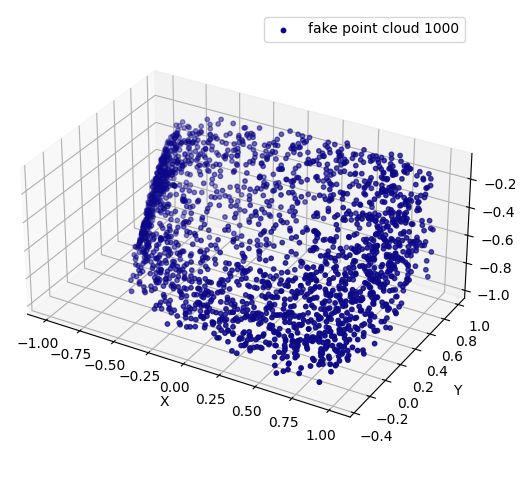

Epoch [1000/5000], Generator Loss: 0.6796501874923706, Discriminator Loss: 1.2789361476898193


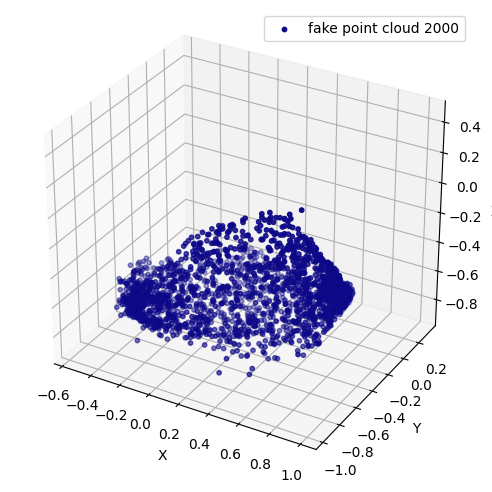

Epoch [2000/5000], Generator Loss: 0.8812581896781921, Discriminator Loss: 1.2450546026229858


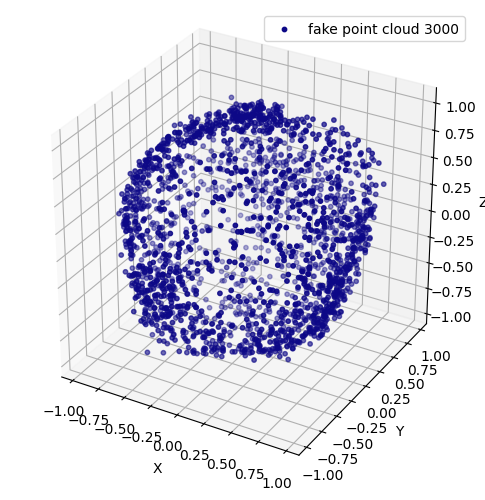

Epoch [3000/5000], Generator Loss: 0.7226493954658508, Discriminator Loss: 1.379713773727417


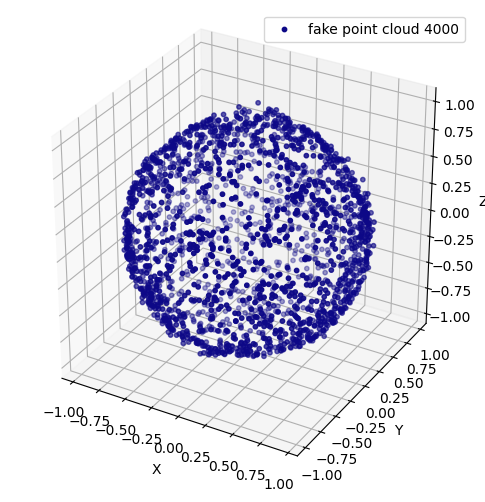

Epoch [4000/5000], Generator Loss: 0.7014654278755188, Discriminator Loss: 1.3784024715423584


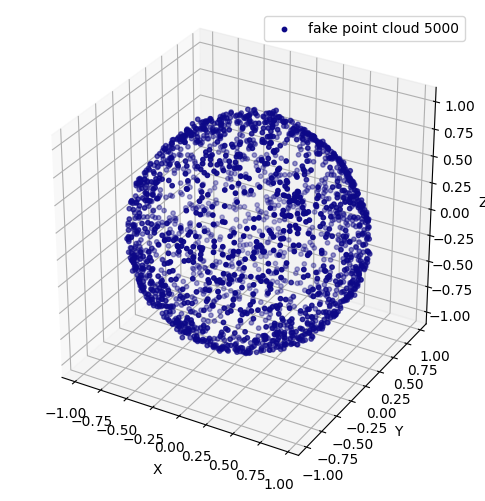

Epoch [5000/5000], Generator Loss: 0.6778771877288818, Discriminator Loss: 1.3805888891220093


In [24]:
# Generator network
class Generator(nn.Module):
    def __init__(self, input_dim=3, output_dim=3, hidden_dim=128):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.tanh(self.fc4(x))  # Outputs points in the range [-1, 1]
        
        return x

# Discriminator network
class Discriminator(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=128):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))  # Outputs a probability (0-1)
        
        return x


torch.manual_seed(1)

# Define loss functions
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss

# Initialize Generator and Discriminator
generator = Generator()
discriminator = Discriminator()

# Define optimizers
optimizer_g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

num_epochs = 5000

losses_g = []
losses_d = []

# Training loop
for epoch in range(1, num_epochs + 1):
    # for real_point_cloud in dataloader:
    # Update Discriminator
    
    optimizer_d.zero_grad()
    real_labels = torch.ones(train_data.shape[0], 1)
    fake_labels = torch.zeros(train_data.shape[0], 1)

    # Compute Discriminator loss for real point clouds
    output_real = discriminator(train_data)
    loss_real = criterion(output_real, real_labels)
    
    noise = torch.randn(train_data.shape[0], 3)

    # Generate fake point clouds and compute Discriminator loss
    fake_point_cloud = generator(noise)
        
    output_fake = discriminator(fake_point_cloud.detach())
    loss_fake = criterion(output_fake, fake_labels)

    # Total Discriminator loss
    loss_d = loss_real + loss_fake
    loss_d.backward()
    optimizer_d.step()

    # Update Generator
    optimizer_g.zero_grad()
    output_fake = discriminator(fake_point_cloud)
    loss_g = criterion(output_fake, real_labels)
    loss_g.backward()
    optimizer_g.step()
    
    losses_g.append(loss_g.item())
    losses_d.append(loss_d.item())
    
    if epoch % 1000 == 0:
        pcshow(fake_point_cloud.detach().numpy(), labels=[f"fake point cloud {epoch}"])

        # Print loss values for this epoch
        print(f"Epoch [{epoch}/{num_epochs}], "
            f"Generator Loss: {loss_g.item()}, "
            f"Discriminator Loss: {loss_d.item()}")

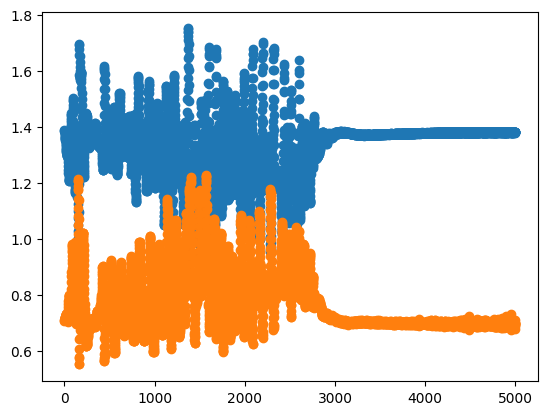

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111)

xe = range(num_epochs)
ax.scatter(xe, losses_d)
ax.scatter(xe, losses_g)

plt.show()

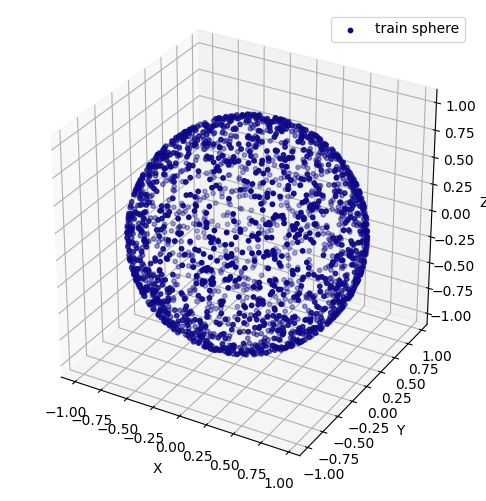

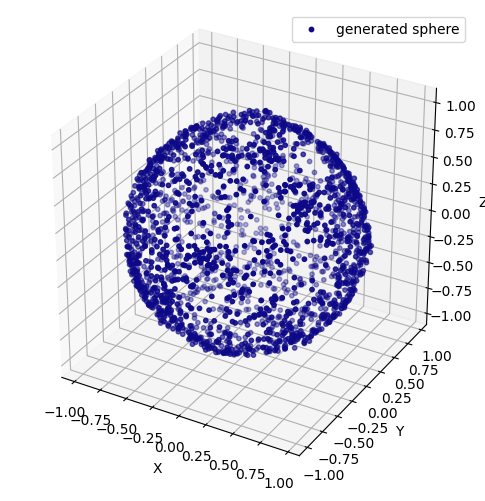

In [26]:
with torch.no_grad():
    pcshow(train_data, labels=["train sphere"])
    pcshow(generator(torch.randn(train_data.shape[0], 3)), labels=["generated sphere"])
    